### Conectando algumas camadas do encoder com o decoder

O treinamento dos autoencoders pode se tornar mais eficiente. Uma técnica que podemos utilizar para otimizar esse treinamento é a cópia das camadas de encoder para o decoder. Como vimos nos slides, essa técnica se assemelha a ideia de espelhar o encoder no decoder. Com isso, temos um treinamento mais eficiente em termos computacionais. 



### Importando as bibliotecas necessárias

In [ ]:
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

### Estendendo o tipo de camada do Keras para permitir a cópia dos pesos entre as camadas

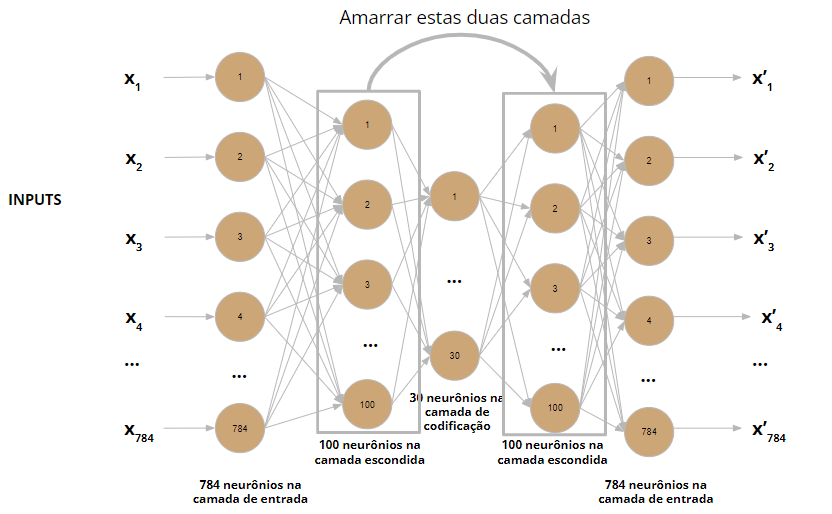

In [ ]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                      shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

### Criando o modelo

In [ ]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])


tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [ ]:
tied_encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
Total params: 81,530
Trainable params: 81,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tied_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_transpose (DenseTrans  (None, 100)              3130      
 pose)                                                           
                                                                 
 dense_transpose_1 (DenseTra  (None, 784)              79284     
 nspose)                                                         
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


### Número de pesos

Percebam que o número de pesos totais do modelo diminuem drasticamente. O número de pesos do autoencoder fica aproximadamente a metade do autoencoder que fizemos no exemplo de TransferLearning.

In [ ]:
tied_ae.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 30)                81530     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            82414     
                                                                 
Total params: 82,414
Trainable params: 82,414
Non-trainable params: 0
_________________________________________________________________


In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [ ]:
tied_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [ ]:
history = tied_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 22s 12ms/step - loss: 0.1503 - rounded_accuracy: 0.9379 - val_loss: 0.1177 - val_rounded_accuracy: 0.9554
Epoch 2/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.1089 - rounded_accuracy: 0.9614 - val_loss: 0.1036 - val_rounded_accuracy: 0.9648
Epoch 3/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1026 - rounded_accuracy: 0.9649 - val_loss: 0.1025 - val_rounded_accuracy: 0.9645
Epoch 4/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.0998 - rounded_accuracy: 0.9664 - val_loss: 0.0999 - val_rounded_accuracy: 0.9668
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0981 - rounded_accuracy: 0.9673 - val_loss: 0.0980 - val_rounded_accuracy: 0.9673
Epoch 6/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.0969 - rounded_accuracy: 0.9679 - val_loss: 0.0963 - val_rounded_accuracy: 0.9685
Epoch 7/10
1719/1719 [==============

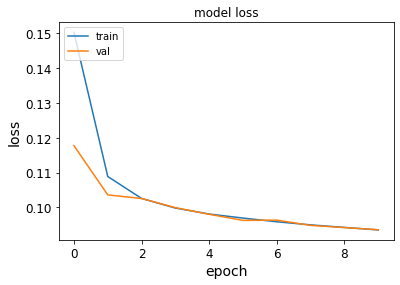

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

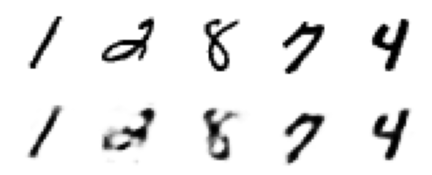

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(tied_ae)